<a href="https://colab.research.google.com/github/maincarey/Healthcare/blob/master/ACLPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://pypi.python.org/pypi/libarchive
# zip to open up the mri dataset  7zip
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
import libarchive

In [0]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook


train_acl = pd.read_csv('/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/train-acl.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head(20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  import sys


,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0
5,0005,0
6,0006,0
7,0007,0
8,0008,0
9,0009,0


In [0]:
print(train_acl.shape)

(1130, 2)


In [0]:
train_acl.Abnormal.value_counts(normalize=True)

0    0.815929
1    0.184071
Name: Abnormal, dtype: float64

In [0]:
case = '0000'

mri_coronal = np.load('/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/train/coronal/0003.npy')
mri_axial = np.load('/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/train/axial/0003.npy')
mri_sagittal = np.load('/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/train/sagittal/0003.npy')

print(f'MRI scan on coronal plane: {mri_coronal.shape}')
print(f'MRI scan on axial plane: {mri_axial.shape}')
print(f'MRI scan on sagittal plane: {mri_sagittal.shape}')

KeyboardInterrupt: ignored

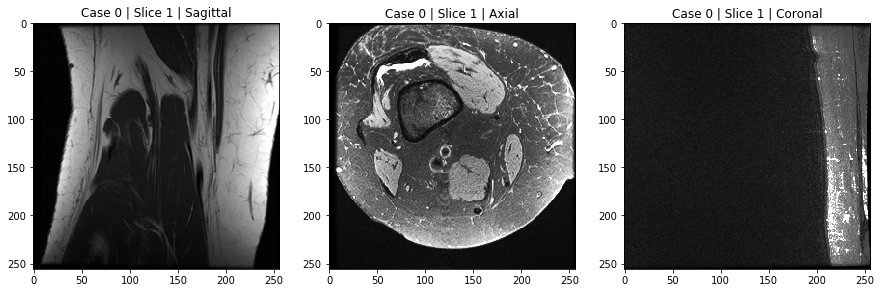

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(mri_coronal[0, :, :], 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal');

ax2.imshow(mri_axial[0, :, :], 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial');

ax3.imshow(mri_sagittal[0, :, :], 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal');

In [0]:
train_path = '/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/train'



def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)
    return np.load(fpath)

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane)
    return x

def load_cases(train=True, n=None):
    assert (type(n) == int) and (n < 1250)
    if train:
        case_list = pd.read_csv('/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/train-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    else:
        case_list = pd.read_csv('/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/valid-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    cases = {}

    if n is not None:
        case_list = case_list[:n]

    for case in tqdm_notebook(case_list, leave=False):
        x = load_stacks(case)
        cases[case] = x
    return cases

cases = load_cases(n=100)

NameError: ignored

In [0]:
print(cases['0000'].keys())

dict_keys(['coronal', 'sagittal', 'axial'])


In [0]:
print(cases['0000']['axial'].shape)
print(cases['0000']['coronal'].shape)
print(cases['0000']['sagittal'].shape)

(44, 256, 256)
(36, 256, 256)
(36, 256, 256)


In [0]:
class KneePlot():
    def __init__(self, cases, figsize=(15, 5)):
        self.cases = cases
        
        self.planes = {case: ['coronal', 'sagittal', 'axial'] for case in self.cases}
    
        self.slice_nums = {}
        for case in self.cases:
            self.slice_nums[case] = {}
            for plane in ['coronal', 'sagittal', 'axial']:
                self.slice_nums[case][plane] = self.cases[case][plane].shape[0]

        self.figsize = figsize
        
    def _plot_slices(self, case, im_slice_coronal, im_slice_sagittal, im_slice_axial):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=self.figsize)
        
        ax1.imshow(self.cases[case]['coronal'][im_slice_coronal, :, :], 'gray')
        ax1.set_title(f'MRI slice {im_slice_coronal} on coronal plane')
        
        ax2.imshow(self.cases[case]['sagittal'][im_slice_sagittal, :, :], 'gray')
        ax2.set_title(f'MRI slice {im_slice_sagittal} on sagittal plane')
        
        ax3.imshow(self.cases[case]['axial'][im_slice_axial, :, :], 'gray')
        ax3.set_title(f'MRI slice {im_slice_axial} on axial plane')
        
        plt.show()
    
    def draw(self):
        case_widget = Dropdown(options=list(self.cases.keys()),
                               description='Case'
                              
                              )
        case_init = list(self.cases.keys())[0]


        slice_init_coronal = self.slice_nums[case_init]['coronal'] - 1        
        slices_widget_coronal = IntSlider(min=0, 
                                          max=slice_init_coronal, 
                                          value=slice_init_coronal // 2, 
                                          description='Coronal')
        
        slice_init_sagittal = self.slice_nums[case_init]['sagittal'] - 1        
        slices_widget_sagittal = IntSlider(min=0,
                                           max=slice_init_sagittal,
                                           value=slice_init_sagittal // 2,
                                           description='Sagittal'
                                          )
        
        slice_init_axial = self.slice_nums[case_init]['axial'] - 1        
        slices_widget_axial = IntSlider(min=0,
                                        max=slice_init_axial,
                                        value=slice_init_axial // 2,
                                        description='Axial'
                                       )
        
        def update_slices_widget(*args):
            slices_widget_coronal.max = self.slice_nums[case_widget.value]['coronal'] - 1
            slices_widget_coronal.value = slices_widget_coronal.max // 2
            
            slices_widget_sagittal.max = self.slice_nums[case_widget.value]['sagittal'] - 1
            slices_widget_sagittal.value = slices_widget_sagittal.max // 2
            
            slices_widget_axial.max = self.slice_nums[case_widget.value]['axial'] - 1
            slices_widget_axial.value = slices_widget_axial.max // 2
    
        
        case_widget.observe(update_slices_widget, 'value')
        interact(self._plot_slices,
                 case=case_widget, 
                 im_slice_coronal=slices_widget_coronal, 
                 im_slice_sagittal=slices_widget_sagittal, 
                 im_slice_axial=slices_widget_axial
                )
    
    def resize(self, figsize): 
        self.figsize = figsize

In [0]:
plot = KneePlot(cases)
plot.draw()

interactive(children=(Dropdown(description='Case', options=('0000', '0001', '0002', '0003', '0004', '0005', '0…

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import keras

Using TensorFlow backend.


In [0]:
#root_dir: ./data/
#task: either acl, meniscus or abnormal. we'll focus on acl in this post
#plane: either sagittal, coronal or axial
#train: a boolean variable that indicates whether we are processing train data or not (validation)
#transform: the series of data augmentation operations. If None, no data augmentation
#weights: custom weights for each class (default to None): this is used to adjust the loss function. When None, weights are computed automatically.

root_dir = '/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/'
#self.plane = {case: ['coronal', 'sagittal', 'axial'] for case in self.cases}
#plane = ['coronal', 'sagittal', 'axial']
#task = 'acl'


import os
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as data
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random
#from torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, ToTensor, Compose, RandomAffine


class MRIDataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()
        

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = torch.FloatTensor([1, neg / pos])
        else:
            self.weights = torch.FloatTensor(weights)
            
    # custom memory pinning method on custom type
    #def pin_memory(self):
     #   self.inp = self.inp.pin_memory()
      #  self.tgt = self.tgt.pin_memory()
       # return self

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])
        label = self.labels[index]
        if label == 1:
            label = torch.FloatTensor([[0, 1]])
        elif label == 0:
            label = torch.FloatTensor([[1, 0]])

        if self.transform:
            array = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=1)
            array = torch.FloatTensor(array)

        # if label.item() == 1:
        #     weight = np.array([self.weights[1]])
        #     weight = torch.FloatTensor(weight)
        # else:
        #     weight = np.array([self.weights[0]])
        #     weight = torch.FloatTensor(weight)

        return array, label, self.weights


In [0]:
#  Model

import torch
import torch.nn as nn
from torchvision import models


class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = models.alexnet(pretrained=True)
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(256, 2)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) 
        features = self.pretrained_model.features(x)
        pooled_features = self.pooling_layer(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
        output = self.classifer(flattened_features)
        return output

In [0]:
import shutil
import os
import time
from datetime import datetime
import argparse
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
#from torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, ToTensor, Compose, RandomAffine
from torchvision import transforms
import torch.nn.functional as F
from tensorboardX import SummaryWriter

from dataloader import MRIDataset
#from dataloader import read_data_sets
import model

from sklearn import metrics


def train_model(model, train_loader, epoch, num_epochs, optimizer, writer, current_lr, log_every=100):
    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()

    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, weight) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0][1]))
        y_preds.append(probas[0][1].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        writer.add_scalar('Train/Loss', loss_value,
                          epoch * len(train_loader) + i)
        writer.add_scalar('Train/AUC', auc, epoch * len(train_loader) + i)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ]| avg train loss {4} | train auc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(train_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Train/AUC_epoch', auc, epoch + i)

    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)
    return train_loss_epoch, train_auc_epoch


def evaluate_model(model, val_loader, epoch, num_epochs, writer, current_lr, log_every=20):
    _ = model.eval()

    if torch.cuda.is_available():
        model.cuda()

    y_trues = []
    y_preds = []
    losses = []

    for i, (image, label, weight) in enumerate(val_loader):

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0][1]))
        y_preds.append(probas[0][1].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        writer.add_scalar('Val/Loss', loss_value, epoch * len(val_loader) + i)
        writer.add_scalar('Val/AUC', auc, epoch * len(val_loader) + i)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ] | avg val loss {4} | val auc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(val_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Val/AUC_epoch', auc, epoch + i)

    val_loss_epoch = np.round(np.mean(losses), 4)
    val_auc_epoch = np.round(auc, 4)
    return val_loss_epoch, val_auc_epoch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def run(args):
    log_root_folder = "./logs/{0}/{1}/".format(args.task, args.plane)
    if args.flush_history == 1:
        objects = os.listdir(log_root_folder)
        for f in objects:
            if os.path.isdir(log_root_folder + f):
                shutil.rmtree(log_root_folder + f)

    now = datetime.now()
    logdir = log_root_folder + now.strftime("%Y%m%d-%H%M%S") + "/"
    os.makedirs(logdir)

    writer = SummaryWriter(logdir)

    augmentor = Compose([
        transforms.Lambda(lambda x: torch.Tensor(x)),
        RandomRotate(25),
        RandomTranslate([0.11, 0.11]),
        RandomFlip(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1, 1).permute(1, 0, 2, 3)),
    ])
    
    
    # changed file paths
    train_dataset = MRIDataset('/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/', args.task,
                              args.plane, transform=augmentor, train=True)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=11, drop_last=False)

    validation_dataset = MRIDataset(
        '/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/', args.task, args.plane, train=False)
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=-True, num_workers=11, drop_last=False)

    mrnet = model.MRNet()

    if torch.cuda.is_available():
        mrnet = mrnet.cuda()

    optimizer = optim.Adam(mrnet.parameters(), lr=args.lr, weight_decay=0.1)

    if args.lr_scheduler == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=3, factor=.3, threshold=1e-4, verbose=True)
    elif args.lr_scheduler == "step":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=3, gamma=args.gamma)

    best_val_loss = float('inf')
    best_val_auc = float(0)

    num_epochs = args.epochs
    iteration_change_loss = 0
    patience = args.patience
    log_every = args.log_every

    t_start_training = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)

        t_start = time.time()
        
        train_loss, train_auc = train_model(
            mrnet, train_loader, epoch, num_epochs, optimizer, writer, current_lr, log_every)
        val_loss, val_auc = evaluate_model(
            mrnet, validation_loader, epoch, num_epochs, writer, current_lr)

        if args.lr_scheduler == 'plateau':
            scheduler.step(val_loss)
        elif args.lr_scheduler == 'step':
            scheduler.step()

        t_end = time.time()
        delta = t_end - t_start

        print("train loss : {0} | train auc {1} | val loss {2} | val auc {3} | elapsed time {4} s".format(
            train_loss, train_auc, val_loss, val_auc, delta))

        iteration_change_loss += 1
        print('-' * 30)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            if bool(args.save_model):
                file_name = f'model_{args.prefix_name}_{args.task}_{args.plane}_val_auc_{val_auc:0.4f}_train_auc_{train_auc:0.4f}_epoch_{epoch+1}.pth'
                for f in os.listdir('./models/'):
                    if (args.task in f) and (args.plane in f) and (args.prefix_name in f):
                        os.remove(f'./models/{f}')
                torch.save(mrnet, f'./models/{file_name}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            iteration_change_loss = 0

        if iteration_change_loss == patience:
            print('Early stopping after {0} iterations without the decrease of the val loss'.
                  format(iteration_change_loss))
            break

    t_end_training = time.time()
    print(f'training took {t_end_training - t_start_training} s')


def parse_arguments():
    parser = argparse.ArgumentParser()
    parser.add_argument('-t', '--task', type=str, required=True,
                        choices=['abnormal', 'acl', 'meniscus'])
    parser.add_argument('-p', '--plane', type=str, required=True,
                        choices=['sagittal', 'coronal', 'axial'])
    parser.add_argument('--prefix_name', type=str, required=True)
    parser.add_argument('--augment', type=int, choices=[0, 1], default=1)
    parser.add_argument('--lr_scheduler', type=str,
                        default='plateau', choices=['plateau', 'step'])
    parser.add_argument('--gamma', type=float, default=0.5)
    parser.add_argument('--epochs', type=int, default=5)
    parser.add_argument('--lr', type=float, default=1e-5)
    parser.add_argument('--flush_history', type=int, choices=[0, 1], default=0)
    parser.add_argument('--save_model', type=int, choices=[0, 1], default=1)
    parser.add_argument('--patience', type=int, default=5)
    parser.add_argument('--log_every', type=int, default=100)
    args = parser.parse_args()
    return args


if __name__ == "__main__":
    args = parse_arguments()
    run(args)

ImportError: ignored

In [0]:
!pip install tensorboardX

     |████████████████████████████████| 194kB 2.7MB/s 
     |████████████████████████████████| 1.3MB 44.0MB/s 
  Found existing installation: protobuf 3.7.1
    Uninstalling protobuf-3.7.1:
      Successfully uninstalled protobuf-3.7.1


In [0]:
!pip install dataloader


  Created wheel for dataloader: filename=dataloader-2.0-cp36-none-any.whl size=10102 sha256=e87f35baa3504e6973cbde980d6c1a2eae4a6d060d2d738e126aa7bbc8a42953
  Stored in directory: /root/.cache/pip/wheels/3a/a0/74/7190a79f983c5276ddcfe888612746a633d8ed0c0eaf7fa42d
Successfully built dataloader


In [0]:

import os
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as data
from torchvision import transforms
import random
#import DataLoader

if __name__ == '__main__':
    from torch.utils.data import DataLoader
    dataset = TESNamesDataset('/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/train/axial')
    dataloader = DataLoader(dataset, batch_size=50, shuffle=True, num_workers=2)
    for i, batch in enumerate(dataloader):
        print(i, batch)

NameError: ignored

In [0]:
root_dir = '/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/'
#self.plane = {case: ['coronal', 'sagittal', 'axial'] for case in self.cases}
plane = ['coronal', 'sagittal', 'axial']
task = 'acl'


import os
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as data
from torchvision import transforms
import random
#from torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, ToTensor, Compose, RandomAffine


class MRIDataset(data.Dataset):
    def __init__(self, root_dir, task='acl', plane=['coronal', 'sagittal', 'axial'], train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = torch.FloatTensor([1, neg / pos])
        else:
            self.weights = torch.FloatTensor(weights)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])
        label = self.labels[index]
        if label == 1:
            label = torch.FloatTensor([[0, 1]])
        elif label == 0:
            label = torch.FloatTensor([[1, 0]])

        if self.transform:
            array = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=1)
            array = torch.FloatTensor(array)

        # if label.item() == 1:
        #     weight = np.array([self.weights[1]])
        #     weight = torch.FloatTensor(weight)
        # else:
        #     weight = np.array([self.weights[0]])
        #     weight = torch.FloatTensor(weight)

        return array, label, self.weights
      
      
if __name__ == '__main__':
    from torch.utils.data import DataLoader
    args = parse_arguments()
    run(args)
    dataset = MRIDataset('/content/drive/My Drive/AI/Machine Learning/Projects/MRI Prediction Stanford/MRNet-v1.0/')
    dataloader = DataLoader(dataset, batch_size=50, shuffle=True, num_workers=2)
    for i, batch in enumerate(dataloader):
        print(i, batch)
        
       # ('-p', '--plane', type=str, required=True, choices=['sagittal', 'coronal', 'axial'])


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa22be04940>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
usage: ipykernel_launcher.py [-h] -t {abnormal,acl,meniscus} -p
                             {sagittal,coronal,axial} --prefix_name
                             PRE

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [0]:
def parse_arguments():
    parser = argparse.ArgumentParser()
    parser.add_argument('-t', '--task', type=str, required=True,
                        choices=['abnormal', 'acl', 'meniscus'])
    parser.add_argument('-p', '--plane', type=str, required=True,
                        choices=['sagittal', 'coronal', 'axial'])
    parser.add_argument('--prefix_name', type=str, required=True)
    parser.add_argument('--augment', type=int, choices=[0, 1], default=1)
    parser.add_argument('--lr_scheduler', type=str,
                        default='plateau', choices=['plateau', 'step'])
    parser.add_argument('--gamma', type=float, default=0.5)
    parser.add_argument('--epochs', type=int, default=5)
    parser.add_argument('--lr', type=float, default=1e-5)
    parser.add_argument('--flush_history', type=int, choices=[0, 1], default=0)
    parser.add_argument('--save_model', type=int, choices=[0, 1], default=1)
    parser.add_argument('--patience', type=int, default=5)
    parser.add_argument('--log_every', type=int, default=100)
    args = parser.parse_args()
    return args